In [12]:
from dotenv import load_dotenv
import os

load_dotenv()
COHERE_API_KEY = os.getenv("COHERE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

In [13]:
# Create the Cohere chat model
from langchain_cohere.chat_models import ChatCohere
os.environ["COHERE_API_KEY"] = COHERE_API_KEY
chat = ChatCohere(model="command-r-plus", temperature=0.2)

Tool 1: web search

In [14]:
from langchain_community.tools import TavilySearchResults

os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

internet_search = TavilySearchResults(
    max_results=10,
    include_answer=True,
    include_raw_content=True,
    include_images=False
    )
internet_search.name = "internet_search"
internet_search.description = "Returns a list of relevant document snippets for a textual query retrieved from the internet."


# from langchain_core.pydantic_v1 import BaseModel, Field
# class TavilySearchInput(BaseModel):
#     query: str = Field(description="Query to search the internet with")
# internet_search.args_schema = TavilySearchInput

In [15]:
# from langchain_community.tools import DuckDuckGoSearchResults

# internet_search = DuckDuckGoSearchResults(max_results=10)
# internet_search.name = "internet_search"
# internet_search.description = "Returns a list of relevant document snippets for a textual query retrieved from the internet."

In [16]:
# internet_search.invoke({'query': 'Create a plot of the monthly average of gold price in swiss franc by gramm for the last 10 years'})

Tool 2: plot

In [17]:
import matplotlib
import pandas
import datetime
from langchain.agents import Tool
from langchain_experimental.utilities import PythonREPL

python_repl = PythonREPL()
repl_tool = Tool(
    name="python_repl",
    description="Executes python code and returns the result. The code runs in a static sandbox without interactive mode, so print output or save output to a file.",
    func=python_repl.run,
)
repl_tool.name = "python_interpreter"

# from langchain_core.pydantic_v1 import BaseModel, Field
# class ToolInput(BaseModel):
#     code: str = Field(description="Python code to execute.")
# repl_tool.args_schema = ToolInput

Insights

In [18]:
import re
import numpy as np
# Define insights tool
def insights_analysis(data: str) -> str:
    # Extract numerical values from text
    numbers = list(map(int, re.findall(r'\d+', data)))

    if not numbers:
        return "No numerical data found for insights."

    # Compute statistics
    min_value = np.min(numbers)
    max_value = np.max(numbers)
    mean_value = np.mean(numbers)
    std_dev = np.std(numbers)

    insights = (
        f"Insights from the data:\n"
        f"- Minimum value: {min_value}\n"
        f"- Maximum value: {max_value}\n"
        f"- Average: {mean_value:.2f}\n"
        f"- Standard Deviation: {std_dev:.2f}"
    )

    return insights

insight = Tool(
        name="Insights Analysis",
        func=insights_analysis,
        description="Analyze the results to provide insights such as min, max, average, and trends."
    )

In [23]:
# Function to convert text to numeric values
def convert_to_numeric(text):
    try:
        return float(text) if '.' in text else int(text)
    except ValueError:
        return "Conversion to numeric failed."

# Define the numeric conversion tool
numeric_conversion_tool = Tool(
    name="NumericConverter",
    func=convert_to_numeric,
    description="Converts textual results into numeric format if possible."
)

Agent

In [31]:
from langchain.agents import AgentExecutor
from langchain_cohere.react_multi_hop.agent import create_cohere_react_agent
from langchain_core.prompts import ChatPromptTemplate

# Create the prompt
prompt = ChatPromptTemplate.from_template("{input}")


# Create the ReAct agent
agent = create_cohere_react_agent(
    llm=chat,
    tools=[internet_search,repl_tool],
    # tools=[internet_search],
    prompt=prompt,
)

agent_executor = AgentExecutor(
    agent=agent,
    tools=[internet_search, repl_tool],
    # tools=[internet_search],
    verbose=True
)

In [32]:
import json
import lxml



> Entering new AgentExecutor chain...

I will search for the number of Google employees in the last decade. I will then write and execute Python code to plot the data and provide insights.
{'tool_name': 'internet_search', 'parameters': {'query': 'number of Google employees in the last decade'}}
[{'url': 'https://explodingtopics.com/blog/how-many-people-work-at-google', 'content': "Number of Google Employees (2024) Top Google Employees Statistics According to the latest available data, there are 182,502 total full-time Alphabet (Google) employees. Number Of Google Employees Over Time Between 2001 and 2010, the number of Google employees increased by approximately 24,200, from 284 to 24,400. Since 2001, the number of Google employees has increased by over 182,000, or 64,161%. Here’s a more detailed breakdown of the number of Google employees over time: Google Workforce By Gender Google Workforce By Ethnicity Asian Google employees make up 44.8% of the company's workforce, while Hispani

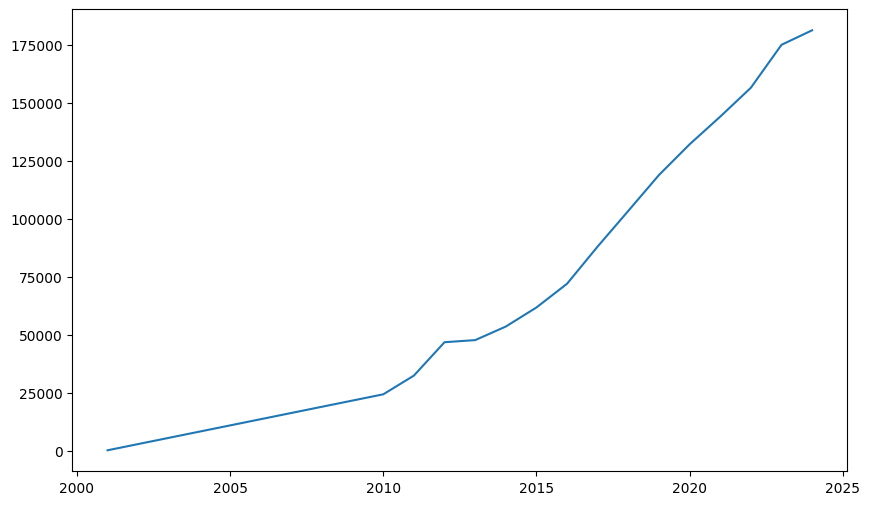

In [34]:
try:
    result = agent_executor.invoke({
        # "input": "Plot the gold price history in us dollar by once for the last month day by day and provide insights",
        "input": "Fing the number of Google employees in the last decade, transform it to numerics and plot it. Give some insights about the plot."
    })
except AttributeError as e:
    print(f"Error: {e}")